In [2]:
import os
from glob import glob
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import random
import albumentations as A
from albumentations.pytorch import ToTensorV2

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
# 1. Dataset definition
class LeafSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, target_size=(256, 256)):
        self.image_paths = sorted(glob(os.path.join(image_dir, '*.jpg')))
        self.mask_paths = sorted(glob(os.path.join(mask_dir, '*.png')))
        self.transform = transform
        self.target_size = target_size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = np.array(Image.open(self.image_paths[idx]).convert('RGB').resize(self.target_size))
        mask = np.array(Image.open(self.mask_paths[idx]).convert('L').resize(self.target_size))

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask'].unsqueeze(0)  # add channel dim for binary mask
        else:
            img = transforms.ToTensor()(img)
            mask = transforms.ToTensor()(mask)

        mask = (mask > 0).float()  # binary
        return img, mask

# Augmentation transform using albumentations
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussianBlur(p=0.3),
    A.RandomShadow(p=0.3),
    
    # Update 1 - Added more augmentation
    A.ElasticTransform(p=0.3, alpha=1, sigma=50),
    A.GridDropout(p=0.5),
    
    A.Resize(256, 256),
    # A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)),
    
    # Update 2 - Menggunakan nilai statistik dari ImageNet
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(256, 256),
    # A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)),
    
    # Update 2 - Menggunakan nilai statistik dari ImageNet
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

In [5]:
# 2. UNet model (PyTorch)
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1, features=[64,128,256,512]):
        super(UNet, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        # Down path
        for feat in features:
            self.downs.append(DoubleConv(n_channels, feat))
            n_channels = feat
        # Up path
        for feat in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feat*2, feat, kernel_size=2, stride=2)
            )
            self.ups.append(DoubleConv(feat*2, feat))
        
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)

        # Update 4 - Modifikasi bottleneck untuk menyertakan Dropout
        self.bottleneck = nn.Sequential(
            DoubleConv(features[-1], features[-1]*2),
            nn.Dropout(p=0.5)
        )
        
        self.final_conv = nn.Conv2d(features[0], n_classes, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = nn.MaxPool2d(kernel_size=2, stride=2)(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip = skip_connections[idx//2]
            if x.shape != skip.shape:
                x = torch.nn.functional.interpolate(x, size=skip.shape[2:])
            x = torch.cat((skip, x), dim=1)
            x = self.ups[idx+1](x)
        
        # Update 2
        return self.final_conv(x)
        
        # return torch.sigmoid(self.final_conv(x))

In [6]:
# 3. Metrics

def iou_score(preds, targets, threshold=0.5):
    preds = (preds > threshold).float()
    intersection = (preds * targets).sum(dim=(1,2,3))
    union = ((preds + targets) > 0).float().sum(dim=(1,2,3))
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean().item()

def dice_coef(preds, targets, threshold=0.5):
    preds = (preds > threshold).float()
    intersection = (preds * targets).sum(dim=(1,2,3))
    dice = (2. * intersection + 1e-6) / (preds.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3)) + 1e-6)
    return dice.mean().item()

def dice_loss(preds, targets):
    smooth = 1e-6
    intersection = (preds * targets).sum(dim=(1,2,3))
    dice = (2. * intersection + smooth) / (preds.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3)) + smooth)
    return 1 - dice.mean()

# Update 2 - Loss Function Dice + BCE
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1e-6):        
        inputs = torch.sigmoid(inputs)
        
        # Meratakan tensor label dan prediksi
        inputs_flat = inputs.view(-1)
        targets_flat = targets.view(-1)
        
        bce_loss = nn.BCELoss()(inputs_flat, targets_flat)
        dice_loss_val = dice_loss(inputs, targets)
        
        # bisa diberi bobot, bobot awal 1:1
        return bce_loss + dice_loss_val

In [7]:
# 4. Training loop
def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0
    for imgs, masks in tqdm(loader):
        imgs, masks = imgs.to(device), masks.to(device)
        preds = model(imgs)
        loss = criterion(preds, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss/len(loader)

def evaluate(model, loader, device):
    model.eval()
    iou_total, dice_total, count = 0, 0, 0
    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            iou_total += iou_score(preds, masks)
            dice_total += dice_coef(preds, masks)
            count += 1
    return iou_total / count, dice_total / count

In [8]:
DATA_DIR = '/kaggle/input/leaf-disease-segmentation-with-trainvalid-split/leaf_disease_segmentation'
ORIG_DATA_DIR = os.path.join(DATA_DIR, 'orig_data')
AUG_DATA_DIR = os.path.join(DATA_DIR, 'aug_data')

# train_images = os.path.join(ORIG_DATA_DIR, 'train_images')
# train_masks = os.path.join(ORIG_DATA_DIR, 'train_masks')

# Update 5 - Menggunakan dataset augmentasi
train_images = os.path.join(AUG_DATA_DIR, 'train_images')
train_masks = os.path.join(AUG_DATA_DIR, 'train_masks')

val_images = os.path.join(ORIG_DATA_DIR, 'valid_images')
val_masks = os.path.join(ORIG_DATA_DIR, 'valid_masks')

In [12]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import CosineAnnealingLR

# Hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lr = 1e-4
# batch_size = 8

# Update 5 - Menambah Jumlah Batch
batch_size = 16

epochs = 150
best_iou = 0
patience = 10  # Jumlah epoch sebelum berhenti
epochs_no_improve = 0

# Data loaders
train_ds = LeafSegmentationDataset(train_images, train_masks, train_transform)
val_ds = LeafSegmentationDataset(val_images, val_masks, val_transform)

print(f"Train samples: {len(train_ds)}, Validation samples: {len(val_ds)}")

if len(train_ds) == 0 or len(val_ds) == 0:
    raise ValueError("Empty Dataset ! Please check image path and folder")

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4)

model = UNet().to(device)
# criterion = dice_loss

 # Update 2 - Gunakan loss gabungan
criterion = DiceBCELoss().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Update 1 - Using Scheduler
# scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

# Update 3 - optimizer AdamW dan scheduler CosineAnnealingLR
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)

# History for plotting
history = {'loss': [], 'iou': [], 'dice': []}

for epoch in range(epochs):
     train_loss = train(model, train_loader, criterion, optimizer, device)
     iou, dice = evaluate(model, val_loader, device)    
     print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, IoU: {iou:.4f}, Dice: {dice:.4f}")

     # Update 1 - Step scheduler
     # scheduler.step(iou)

     # Update 3 
     scheduler.step()

     # Checkpoint best model
     if iou > best_iou:
        best_iou = iou
        torch.save(model.state_dict(), 'best_model.pth')
        print(">> Saved best model!")
        epochs_no_improve = 0
     else:
        epochs_no_improve += 1
         
     if epochs_no_improve == patience:
        print(f"Early stopping triggered after {patience} epochs with no improvement.")
        break
        
     history['loss'].append(train_loss)
     history['iou'].append(iou)
     history['dice'].append(dice)

Train samples: 2500, Validation samples: 90


100%|██████████| 157/157 [01:03<00:00,  2.48it/s]


Epoch 1/150, Train Loss: 1.0245, IoU: 0.4634, Dice: 0.6051
>> Saved best model!


100%|██████████| 157/157 [01:03<00:00,  2.48it/s]


Epoch 2/150, Train Loss: 0.8812, IoU: 0.4894, Dice: 0.6253
>> Saved best model!


100%|██████████| 157/157 [01:03<00:00,  2.48it/s]


Epoch 3/150, Train Loss: 0.8166, IoU: 0.5007, Dice: 0.6447
>> Saved best model!


100%|██████████| 157/157 [01:03<00:00,  2.47it/s]


Epoch 4/150, Train Loss: 0.7743, IoU: 0.5053, Dice: 0.6483
>> Saved best model!


100%|██████████| 157/157 [01:03<00:00,  2.48it/s]


Epoch 5/150, Train Loss: 0.7366, IoU: 0.5432, Dice: 0.6774
>> Saved best model!


100%|██████████| 157/157 [01:03<00:00,  2.47it/s]


Epoch 6/150, Train Loss: 0.7052, IoU: 0.5556, Dice: 0.6934
>> Saved best model!


100%|██████████| 157/157 [01:03<00:00,  2.47it/s]


Epoch 7/150, Train Loss: 0.6790, IoU: 0.4928, Dice: 0.6293


100%|██████████| 157/157 [01:03<00:00,  2.49it/s]


Epoch 8/150, Train Loss: 0.6543, IoU: 0.5748, Dice: 0.7105
>> Saved best model!


100%|██████████| 157/157 [01:03<00:00,  2.47it/s]


Epoch 9/150, Train Loss: 0.6300, IoU: 0.5887, Dice: 0.7200
>> Saved best model!


100%|██████████| 157/157 [01:03<00:00,  2.47it/s]


Epoch 10/150, Train Loss: 0.6143, IoU: 0.5410, Dice: 0.6799


100%|██████████| 157/157 [01:03<00:00,  2.47it/s]


Epoch 11/150, Train Loss: 0.6026, IoU: 0.6272, Dice: 0.7558
>> Saved best model!


100%|██████████| 157/157 [01:03<00:00,  2.48it/s]


Epoch 12/150, Train Loss: 0.5669, IoU: 0.6313, Dice: 0.7552
>> Saved best model!


100%|██████████| 157/157 [01:03<00:00,  2.47it/s]


Epoch 13/150, Train Loss: 0.5627, IoU: 0.6371, Dice: 0.7618
>> Saved best model!


100%|██████████| 157/157 [01:03<00:00,  2.48it/s]


Epoch 14/150, Train Loss: 0.5604, IoU: 0.6526, Dice: 0.7737
>> Saved best model!


100%|██████████| 157/157 [01:03<00:00,  2.46it/s]


Epoch 15/150, Train Loss: 0.5452, IoU: 0.6180, Dice: 0.7417


100%|██████████| 157/157 [01:03<00:00,  2.48it/s]


Epoch 16/150, Train Loss: 0.5338, IoU: 0.6463, Dice: 0.7696


100%|██████████| 157/157 [01:03<00:00,  2.46it/s]


Epoch 17/150, Train Loss: 0.5349, IoU: 0.6393, Dice: 0.7649


100%|██████████| 157/157 [01:03<00:00,  2.48it/s]


Epoch 18/150, Train Loss: 0.5222, IoU: 0.6669, Dice: 0.7875
>> Saved best model!


100%|██████████| 157/157 [01:03<00:00,  2.48it/s]


Epoch 19/150, Train Loss: 0.5088, IoU: 0.6824, Dice: 0.7977
>> Saved best model!


100%|██████████| 157/157 [01:03<00:00,  2.47it/s]


Epoch 20/150, Train Loss: 0.5042, IoU: 0.6835, Dice: 0.7971
>> Saved best model!


100%|██████████| 157/157 [01:03<00:00,  2.47it/s]


Epoch 21/150, Train Loss: 0.5051, IoU: 0.6737, Dice: 0.7908


100%|██████████| 157/157 [01:03<00:00,  2.46it/s]


Epoch 22/150, Train Loss: 0.4964, IoU: 0.6902, Dice: 0.8046
>> Saved best model!


100%|██████████| 157/157 [01:03<00:00,  2.46it/s]


Epoch 23/150, Train Loss: 0.4889, IoU: 0.6900, Dice: 0.8045


100%|██████████| 157/157 [01:03<00:00,  2.47it/s]


Epoch 24/150, Train Loss: 0.4851, IoU: 0.6966, Dice: 0.8083
>> Saved best model!


100%|██████████| 157/157 [01:03<00:00,  2.47it/s]


Epoch 25/150, Train Loss: 0.4724, IoU: 0.7018, Dice: 0.8142
>> Saved best model!


100%|██████████| 157/157 [01:04<00:00,  2.45it/s]


Epoch 26/150, Train Loss: 0.4675, IoU: 0.7154, Dice: 0.8248
>> Saved best model!


100%|██████████| 157/157 [01:03<00:00,  2.46it/s]


Epoch 27/150, Train Loss: 0.4633, IoU: 0.7154, Dice: 0.8222
>> Saved best model!


100%|██████████| 157/157 [01:03<00:00,  2.46it/s]


Epoch 28/150, Train Loss: 0.4524, IoU: 0.6987, Dice: 0.8125


100%|██████████| 157/157 [01:04<00:00,  2.44it/s]


Epoch 29/150, Train Loss: 0.4445, IoU: 0.7183, Dice: 0.8262
>> Saved best model!


100%|██████████| 157/157 [01:03<00:00,  2.47it/s]


Epoch 30/150, Train Loss: 0.4362, IoU: 0.7089, Dice: 0.8222


100%|██████████| 157/157 [01:03<00:00,  2.47it/s]


Epoch 31/150, Train Loss: 0.4359, IoU: 0.7384, Dice: 0.8419
>> Saved best model!


100%|██████████| 157/157 [01:03<00:00,  2.47it/s]


Epoch 32/150, Train Loss: 0.4283, IoU: 0.7125, Dice: 0.8229


100%|██████████| 157/157 [01:03<00:00,  2.47it/s]


Epoch 33/150, Train Loss: 0.4187, IoU: 0.7372, Dice: 0.8409


100%|██████████| 157/157 [01:03<00:00,  2.46it/s]


Epoch 34/150, Train Loss: 0.4143, IoU: 0.7363, Dice: 0.8416


100%|██████████| 157/157 [01:03<00:00,  2.47it/s]


Epoch 35/150, Train Loss: 0.4105, IoU: 0.7401, Dice: 0.8436
>> Saved best model!


100%|██████████| 157/157 [01:03<00:00,  2.48it/s]


Epoch 36/150, Train Loss: 0.4052, IoU: 0.7085, Dice: 0.8188


100%|██████████| 157/157 [01:03<00:00,  2.48it/s]


Epoch 37/150, Train Loss: 0.4089, IoU: 0.7483, Dice: 0.8485
>> Saved best model!


100%|██████████| 157/157 [01:03<00:00,  2.46it/s]


Epoch 38/150, Train Loss: 0.4070, IoU: 0.7332, Dice: 0.8388


100%|██████████| 157/157 [01:03<00:00,  2.46it/s]


Epoch 39/150, Train Loss: 0.3966, IoU: 0.7383, Dice: 0.8420


100%|██████████| 157/157 [01:03<00:00,  2.47it/s]


Epoch 40/150, Train Loss: 0.3964, IoU: 0.7465, Dice: 0.8472


100%|██████████| 157/157 [01:03<00:00,  2.47it/s]


Epoch 41/150, Train Loss: 0.3894, IoU: 0.7527, Dice: 0.8526
>> Saved best model!


100%|██████████| 157/157 [01:03<00:00,  2.46it/s]


Epoch 42/150, Train Loss: 0.3775, IoU: 0.7550, Dice: 0.8544
>> Saved best model!


100%|██████████| 157/157 [01:03<00:00,  2.45it/s]


Epoch 43/150, Train Loss: 0.3753, IoU: 0.7526, Dice: 0.8516


100%|██████████| 157/157 [01:03<00:00,  2.47it/s]


Epoch 44/150, Train Loss: 0.3791, IoU: 0.7391, Dice: 0.8412


100%|██████████| 157/157 [01:03<00:00,  2.48it/s]


Epoch 45/150, Train Loss: 0.3756, IoU: 0.7641, Dice: 0.8604
>> Saved best model!


100%|██████████| 157/157 [01:03<00:00,  2.47it/s]


Epoch 46/150, Train Loss: 0.3599, IoU: 0.7580, Dice: 0.8565


100%|██████████| 157/157 [01:03<00:00,  2.48it/s]


Epoch 47/150, Train Loss: 0.3673, IoU: 0.7587, Dice: 0.8565


100%|██████████| 157/157 [01:03<00:00,  2.48it/s]


Epoch 48/150, Train Loss: 0.3616, IoU: 0.7599, Dice: 0.8586


100%|██████████| 157/157 [01:03<00:00,  2.47it/s]


Epoch 49/150, Train Loss: 0.3558, IoU: 0.7576, Dice: 0.8560


100%|██████████| 157/157 [01:03<00:00,  2.47it/s]


Epoch 50/150, Train Loss: 0.3519, IoU: 0.7696, Dice: 0.8650
>> Saved best model!


100%|██████████| 157/157 [01:03<00:00,  2.48it/s]


Epoch 51/150, Train Loss: 0.3423, IoU: 0.7567, Dice: 0.8555


100%|██████████| 157/157 [01:03<00:00,  2.46it/s]


Epoch 52/150, Train Loss: 0.3443, IoU: 0.7693, Dice: 0.8649


100%|██████████| 157/157 [01:03<00:00,  2.47it/s]


Epoch 53/150, Train Loss: 0.3385, IoU: 0.7747, Dice: 0.8685
>> Saved best model!


100%|██████████| 157/157 [01:03<00:00,  2.47it/s]


Epoch 54/150, Train Loss: 0.3343, IoU: 0.7643, Dice: 0.8609


100%|██████████| 157/157 [01:03<00:00,  2.47it/s]


Epoch 55/150, Train Loss: 0.3388, IoU: 0.7749, Dice: 0.8686
>> Saved best model!


100%|██████████| 157/157 [01:03<00:00,  2.47it/s]


Epoch 56/150, Train Loss: 0.3305, IoU: 0.7812, Dice: 0.8729
>> Saved best model!


100%|██████████| 157/157 [01:03<00:00,  2.46it/s]


Epoch 57/150, Train Loss: 0.3301, IoU: 0.7890, Dice: 0.8778
>> Saved best model!


100%|██████████| 157/157 [01:03<00:00,  2.47it/s]


Epoch 58/150, Train Loss: 0.3215, IoU: 0.7751, Dice: 0.8685


100%|██████████| 157/157 [01:03<00:00,  2.48it/s]


Epoch 59/150, Train Loss: 0.3146, IoU: 0.7904, Dice: 0.8786
>> Saved best model!


100%|██████████| 157/157 [01:03<00:00,  2.47it/s]


Epoch 60/150, Train Loss: 0.3107, IoU: 0.7762, Dice: 0.8694


100%|██████████| 157/157 [01:04<00:00,  2.45it/s]


Epoch 61/150, Train Loss: 0.3159, IoU: 0.7836, Dice: 0.8746


100%|██████████| 157/157 [01:03<00:00,  2.45it/s]


Epoch 62/150, Train Loss: 0.3145, IoU: 0.7935, Dice: 0.8807
>> Saved best model!


100%|██████████| 157/157 [01:03<00:00,  2.47it/s]


Epoch 63/150, Train Loss: 0.3018, IoU: 0.7900, Dice: 0.8785


100%|██████████| 157/157 [01:03<00:00,  2.47it/s]


Epoch 64/150, Train Loss: 0.3122, IoU: 0.7645, Dice: 0.8620


100%|██████████| 157/157 [01:03<00:00,  2.47it/s]


Epoch 65/150, Train Loss: 0.3022, IoU: 0.7884, Dice: 0.8775


100%|██████████| 157/157 [01:03<00:00,  2.47it/s]


Epoch 66/150, Train Loss: 0.2928, IoU: 0.7878, Dice: 0.8768


100%|██████████| 157/157 [01:03<00:00,  2.46it/s]


Epoch 67/150, Train Loss: 0.2923, IoU: 0.7931, Dice: 0.8806


100%|██████████| 157/157 [01:03<00:00,  2.47it/s]


Epoch 68/150, Train Loss: 0.2952, IoU: 0.8015, Dice: 0.8864
>> Saved best model!


100%|██████████| 157/157 [01:03<00:00,  2.48it/s]


Epoch 69/150, Train Loss: 0.2855, IoU: 0.7965, Dice: 0.8830


100%|██████████| 157/157 [01:03<00:00,  2.47it/s]


Epoch 70/150, Train Loss: 0.2875, IoU: 0.7995, Dice: 0.8850


100%|██████████| 157/157 [01:03<00:00,  2.48it/s]


Epoch 71/150, Train Loss: 0.2834, IoU: 0.8021, Dice: 0.8866
>> Saved best model!


100%|██████████| 157/157 [01:03<00:00,  2.48it/s]


Epoch 72/150, Train Loss: 0.2787, IoU: 0.8013, Dice: 0.8858


100%|██████████| 157/157 [01:03<00:00,  2.48it/s]


Epoch 73/150, Train Loss: 0.2784, IoU: 0.7900, Dice: 0.8782


100%|██████████| 157/157 [01:03<00:00,  2.46it/s]


Epoch 74/150, Train Loss: 0.2776, IoU: 0.8002, Dice: 0.8851


100%|██████████| 157/157 [01:03<00:00,  2.47it/s]


Epoch 75/150, Train Loss: 0.2707, IoU: 0.8079, Dice: 0.8903
>> Saved best model!


100%|██████████| 157/157 [01:03<00:00,  2.48it/s]


Epoch 76/150, Train Loss: 0.2742, IoU: 0.8074, Dice: 0.8901


100%|██████████| 157/157 [01:03<00:00,  2.47it/s]


Epoch 77/150, Train Loss: 0.2705, IoU: 0.8069, Dice: 0.8898


100%|██████████| 157/157 [01:03<00:00,  2.48it/s]


Epoch 78/150, Train Loss: 0.2632, IoU: 0.8094, Dice: 0.8914
>> Saved best model!


100%|██████████| 157/157 [01:03<00:00,  2.48it/s]


Epoch 79/150, Train Loss: 0.2641, IoU: 0.8093, Dice: 0.8911


100%|██████████| 157/157 [01:03<00:00,  2.46it/s]


Epoch 80/150, Train Loss: 0.2651, IoU: 0.8149, Dice: 0.8950
>> Saved best model!


100%|██████████| 157/157 [01:03<00:00,  2.46it/s]


Epoch 81/150, Train Loss: 0.2662, IoU: 0.8096, Dice: 0.8913


100%|██████████| 157/157 [01:03<00:00,  2.47it/s]


Epoch 82/150, Train Loss: 0.2695, IoU: 0.8171, Dice: 0.8961
>> Saved best model!


100%|██████████| 157/157 [01:03<00:00,  2.48it/s]


Epoch 83/150, Train Loss: 0.2534, IoU: 0.8028, Dice: 0.8870


100%|██████████| 157/157 [01:03<00:00,  2.48it/s]


Epoch 84/150, Train Loss: 0.2511, IoU: 0.8151, Dice: 0.8947


100%|██████████| 157/157 [01:03<00:00,  2.47it/s]


Epoch 85/150, Train Loss: 0.2523, IoU: 0.8182, Dice: 0.8971
>> Saved best model!


100%|██████████| 157/157 [01:03<00:00,  2.48it/s]


Epoch 86/150, Train Loss: 0.2500, IoU: 0.8144, Dice: 0.8946


100%|██████████| 157/157 [01:03<00:00,  2.47it/s]


Epoch 87/150, Train Loss: 0.2504, IoU: 0.8155, Dice: 0.8951


100%|██████████| 157/157 [01:03<00:00,  2.48it/s]


Epoch 88/150, Train Loss: 0.2527, IoU: 0.8189, Dice: 0.8975
>> Saved best model!


100%|██████████| 157/157 [01:03<00:00,  2.48it/s]


Epoch 89/150, Train Loss: 0.2490, IoU: 0.8233, Dice: 0.9002
>> Saved best model!


100%|██████████| 157/157 [01:03<00:00,  2.48it/s]


Epoch 90/150, Train Loss: 0.2459, IoU: 0.8228, Dice: 0.8996


100%|██████████| 157/157 [01:03<00:00,  2.47it/s]


Epoch 91/150, Train Loss: 0.2415, IoU: 0.8257, Dice: 0.9015
>> Saved best model!


100%|██████████| 157/157 [01:03<00:00,  2.47it/s]


Epoch 92/150, Train Loss: 0.2387, IoU: 0.8239, Dice: 0.9006


100%|██████████| 157/157 [01:03<00:00,  2.47it/s]


Epoch 93/150, Train Loss: 0.2419, IoU: 0.8250, Dice: 0.9014


100%|██████████| 157/157 [01:04<00:00,  2.45it/s]


Epoch 94/150, Train Loss: 0.2403, IoU: 0.8242, Dice: 0.9007


100%|██████████| 157/157 [01:03<00:00,  2.46it/s]


Epoch 95/150, Train Loss: 0.2344, IoU: 0.8246, Dice: 0.9009


100%|██████████| 157/157 [01:03<00:00,  2.45it/s]


Epoch 96/150, Train Loss: 0.2338, IoU: 0.8260, Dice: 0.9019
>> Saved best model!


100%|██████████| 157/157 [01:03<00:00,  2.47it/s]


Epoch 97/150, Train Loss: 0.2369, IoU: 0.8268, Dice: 0.9025
>> Saved best model!


100%|██████████| 157/157 [01:03<00:00,  2.48it/s]


Epoch 98/150, Train Loss: 0.2322, IoU: 0.8306, Dice: 0.9047
>> Saved best model!


100%|██████████| 157/157 [01:03<00:00,  2.48it/s]


Epoch 99/150, Train Loss: 0.2342, IoU: 0.8307, Dice: 0.9046
>> Saved best model!


100%|██████████| 157/157 [01:03<00:00,  2.47it/s]


Epoch 100/150, Train Loss: 0.2296, IoU: 0.8303, Dice: 0.9046


100%|██████████| 157/157 [01:03<00:00,  2.46it/s]


Epoch 101/150, Train Loss: 0.2289, IoU: 0.8281, Dice: 0.9029


100%|██████████| 157/157 [01:03<00:00,  2.46it/s]


Epoch 102/150, Train Loss: 0.2286, IoU: 0.8332, Dice: 0.9062
>> Saved best model!


100%|██████████| 157/157 [01:03<00:00,  2.47it/s]


Epoch 103/150, Train Loss: 0.2275, IoU: 0.8309, Dice: 0.9047


100%|██████████| 157/157 [01:03<00:00,  2.47it/s]


Epoch 104/150, Train Loss: 0.2246, IoU: 0.8340, Dice: 0.9069
>> Saved best model!


100%|██████████| 157/157 [01:03<00:00,  2.46it/s]


Epoch 105/150, Train Loss: 0.2218, IoU: 0.8342, Dice: 0.9067
>> Saved best model!


100%|██████████| 157/157 [01:03<00:00,  2.46it/s]


Epoch 106/150, Train Loss: 0.2202, IoU: 0.8325, Dice: 0.9056


100%|██████████| 157/157 [01:03<00:00,  2.46it/s]


Epoch 107/150, Train Loss: 0.2221, IoU: 0.8305, Dice: 0.9041


100%|██████████| 157/157 [01:04<00:00,  2.45it/s]


Epoch 108/150, Train Loss: 0.2189, IoU: 0.8335, Dice: 0.9063


100%|██████████| 157/157 [01:03<00:00,  2.47it/s]


Epoch 109/150, Train Loss: 0.2164, IoU: 0.8360, Dice: 0.9079
>> Saved best model!


100%|██████████| 157/157 [01:03<00:00,  2.46it/s]


Epoch 110/150, Train Loss: 0.2133, IoU: 0.8359, Dice: 0.9079


100%|██████████| 157/157 [01:04<00:00,  2.45it/s]


Epoch 111/150, Train Loss: 0.2134, IoU: 0.8363, Dice: 0.9081
>> Saved best model!


100%|██████████| 157/157 [01:03<00:00,  2.46it/s]


Epoch 112/150, Train Loss: 0.2172, IoU: 0.8352, Dice: 0.9072


100%|██████████| 157/157 [01:03<00:00,  2.47it/s]


Epoch 113/150, Train Loss: 0.2129, IoU: 0.8366, Dice: 0.9083
>> Saved best model!


100%|██████████| 157/157 [01:03<00:00,  2.46it/s]


Epoch 114/150, Train Loss: 0.2159, IoU: 0.8378, Dice: 0.9089
>> Saved best model!


100%|██████████| 157/157 [01:03<00:00,  2.47it/s]


Epoch 115/150, Train Loss: 0.2111, IoU: 0.8377, Dice: 0.9090


100%|██████████| 157/157 [01:03<00:00,  2.46it/s]


Epoch 116/150, Train Loss: 0.2105, IoU: 0.8374, Dice: 0.9088


100%|██████████| 157/157 [01:03<00:00,  2.47it/s]


Epoch 117/150, Train Loss: 0.2139, IoU: 0.8425, Dice: 0.9120
>> Saved best model!


100%|██████████| 157/157 [01:03<00:00,  2.47it/s]


Epoch 118/150, Train Loss: 0.2098, IoU: 0.8423, Dice: 0.9118


100%|██████████| 157/157 [01:03<00:00,  2.46it/s]


Epoch 119/150, Train Loss: 0.2087, IoU: 0.8416, Dice: 0.9114


100%|██████████| 157/157 [01:03<00:00,  2.47it/s]


Epoch 120/150, Train Loss: 0.2074, IoU: 0.8404, Dice: 0.9106


100%|██████████| 157/157 [01:03<00:00,  2.48it/s]


Epoch 121/150, Train Loss: 0.2073, IoU: 0.8420, Dice: 0.9116


100%|██████████| 157/157 [01:03<00:00,  2.47it/s]


Epoch 122/150, Train Loss: 0.2069, IoU: 0.8414, Dice: 0.9112


100%|██████████| 157/157 [01:04<00:00,  2.45it/s]


Epoch 123/150, Train Loss: 0.2051, IoU: 0.8405, Dice: 0.9104


100%|██████████| 157/157 [01:03<00:00,  2.48it/s]


Epoch 124/150, Train Loss: 0.2050, IoU: 0.8402, Dice: 0.9103


100%|██████████| 157/157 [01:03<00:00,  2.48it/s]


Epoch 125/150, Train Loss: 0.2066, IoU: 0.8385, Dice: 0.9092


100%|██████████| 157/157 [01:03<00:00,  2.48it/s]


Epoch 126/150, Train Loss: 0.2044, IoU: 0.8436, Dice: 0.9126
>> Saved best model!


100%|██████████| 157/157 [01:03<00:00,  2.48it/s]


Epoch 127/150, Train Loss: 0.2044, IoU: 0.8427, Dice: 0.9120


100%|██████████| 157/157 [01:03<00:00,  2.47it/s]


Epoch 128/150, Train Loss: 0.2032, IoU: 0.8433, Dice: 0.9123


100%|██████████| 157/157 [01:03<00:00,  2.47it/s]


Epoch 129/150, Train Loss: 0.2018, IoU: 0.8433, Dice: 0.9124


100%|██████████| 157/157 [01:03<00:00,  2.47it/s]


Epoch 130/150, Train Loss: 0.2032, IoU: 0.8427, Dice: 0.9120


100%|██████████| 157/157 [01:03<00:00,  2.47it/s]


Epoch 131/150, Train Loss: 0.2029, IoU: 0.8458, Dice: 0.9140
>> Saved best model!


100%|██████████| 157/157 [01:03<00:00,  2.48it/s]


Epoch 132/150, Train Loss: 0.2027, IoU: 0.8433, Dice: 0.9123


100%|██████████| 157/157 [01:03<00:00,  2.48it/s]


Epoch 133/150, Train Loss: 0.2006, IoU: 0.8441, Dice: 0.9129


100%|██████████| 157/157 [01:03<00:00,  2.48it/s]


Epoch 134/150, Train Loss: 0.2009, IoU: 0.8431, Dice: 0.9122


100%|██████████| 157/157 [01:03<00:00,  2.46it/s]


Epoch 135/150, Train Loss: 0.1988, IoU: 0.8428, Dice: 0.9120


100%|██████████| 157/157 [01:03<00:00,  2.47it/s]


Epoch 136/150, Train Loss: 0.1998, IoU: 0.8446, Dice: 0.9132


100%|██████████| 157/157 [01:03<00:00,  2.48it/s]


Epoch 137/150, Train Loss: 0.1994, IoU: 0.8447, Dice: 0.9133


100%|██████████| 157/157 [01:03<00:00,  2.46it/s]


Epoch 138/150, Train Loss: 0.1984, IoU: 0.8441, Dice: 0.9129


100%|██████████| 157/157 [01:03<00:00,  2.48it/s]


Epoch 139/150, Train Loss: 0.2007, IoU: 0.8434, Dice: 0.9123


100%|██████████| 157/157 [01:03<00:00,  2.46it/s]


Epoch 140/150, Train Loss: 0.2013, IoU: 0.8457, Dice: 0.9138


100%|██████████| 157/157 [01:03<00:00,  2.47it/s]


Epoch 141/150, Train Loss: 0.1974, IoU: 0.8450, Dice: 0.9134
Early stopping triggered after 10 epochs with no improvement.


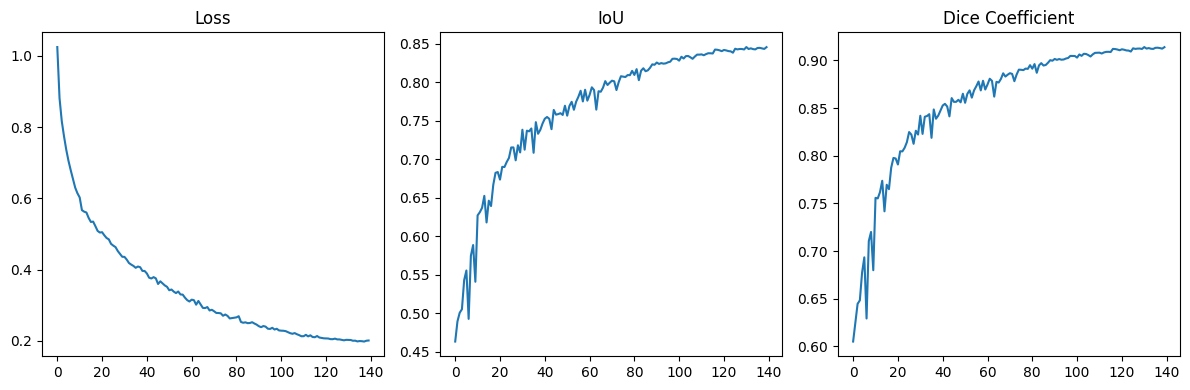


Final Evaluation on Validation Set:
Mean IoU Score: 0.8450
Mean Dice Loss: 0.0866


In [13]:
import matplotlib.pyplot as plt

# Plot training history
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(history['loss'], label='Train Loss')
plt.title('Loss')
plt.subplot(1,3,2)
plt.plot(history['iou'], label='IoU')
plt.title('IoU')
plt.subplot(1,3,3)
plt.plot(history['dice'], label='Dice')
plt.title('Dice Coefficient')
plt.tight_layout()
# plt.savefig("training_history.png")
plt.show()

# Mean IoU and Mean Dice Loss
mean_iou, mean_dice = evaluate(model, val_loader, device)
mean_dice_loss = 1 - mean_dice

print(f"\nFinal Evaluation on Validation Set:")
print(f"Mean IoU Score: {mean_iou:.4f}")
print(f"Mean Dice Loss: {mean_dice_loss:.4f}")

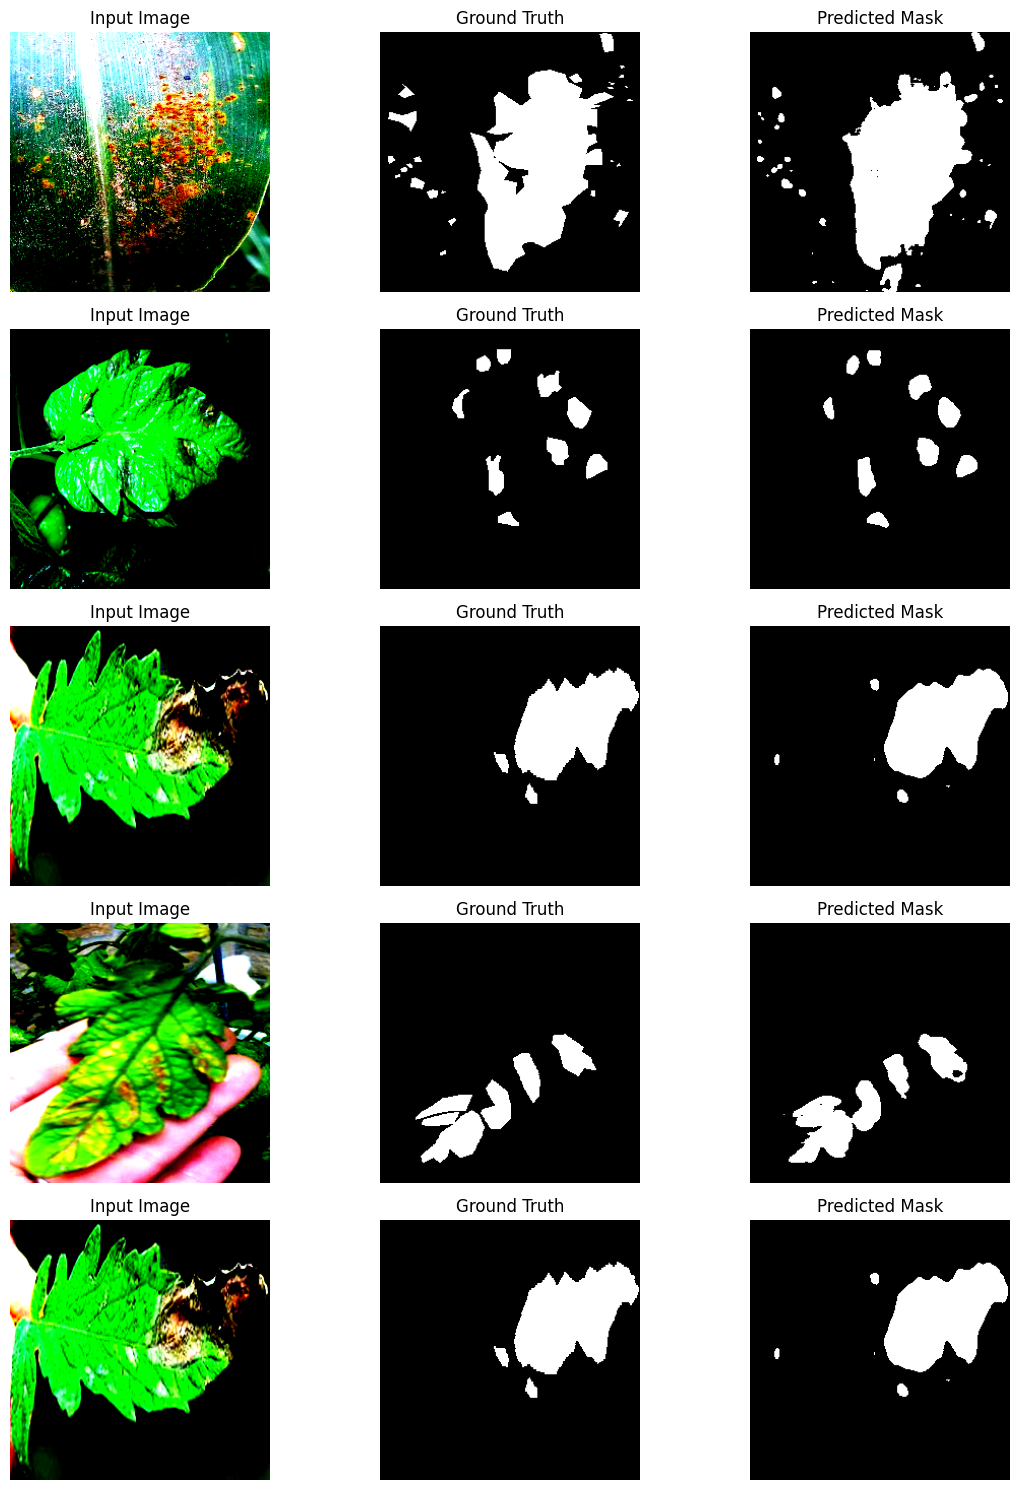

In [15]:
model.eval()
fig, axes = plt.subplots(5, 3, figsize=(12, 15))

for i in range(5):
    idx = random.randint(0, len(val_ds)-1)
    img, mask = val_ds[idx]
    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(device))
        pred_mask = (torch.sigmoid(pred).squeeze().cpu().numpy() > 0.5).astype(np.uint8)

    # Tampilkan gambar
    axes[i, 0].imshow(img.permute(1, 2, 0))
    axes[i, 0].set_title("Input Image")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(mask.squeeze(), cmap="gray")
    axes[i, 1].set_title("Ground Truth")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(pred_mask, cmap="gray")
    axes[i, 2].set_title("Predicted Mask")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()